# PERSIANN - Data Analysis
 - **@author**: Mario Garcia (mario.garcia@utec.edu.uy)
 - **@date**: 2022-07-27
 - **Url**: https://chrsdata.eng.uci.edu/
 - **See**: [03-01 Persiann - DataLake.ipynb](https://colab.research.google.com/drive/1cQESW5s099s4wbT1U7VmMf89fKBimrQ9) 
 - **Output**: 

## Setup

In [ ]:
dir_google_drive = "/content/drive/MyDrive/ValidacionProductosSatelitales(VPS)/Proyecto Colab/04 - Data Ext"
dir_data = './data/'
dir_data_source = dir_data+'/source/'
dir_data_shapefiles = dir_data+'/source/'
dir_var = './var/'
dir_download = dir_var+'/download/'
dir_output = dir_var+'/output/'
dir_log = dir_var+'/log/'



### Libraries

In [ ]:
# https://pypi.org/project/wget/
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f95dcf1fed6bd48a2bf94959c0c5ea61c78c0ebed93817a6c93fc116072b839e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
!pip install geopandas 

In [ ]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Data
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Utils
import wget
import os 
import shutil
import glob
import calendar

# Zip
import zipfile

# NetCDF
import xarray  as xr

# GEO MAPS
# https://jcutrer.com/python/learn-geopandas-plotting-usmaps
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [ ]:
def get_geometry_uruguay():
  df_world_shapes = gpd.read_file(dir_data+"/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp")
  df_uruguay_shapes = df_world_shapes[ df_world_shapes['ISO2'] == 'UY']
  # df_uruguay_shapes
  polygon_uruguay = df_uruguay_shapes['geometry']
  return polygon_uruguay
  # polygon_uruguay = geometry[210]
  # return gpd.GeoSeries(polygon_uruguay)

In [ ]:
def _get_landmask(ds_xr, geometry_region): #geometry_uruguay
  # get lat, lon
  lats = ds_xr['lat'].values
  lons = ds_xr['lon'].values  

  # get coords
  coords = []
  for lat in lats:
    for lon in lons:
      coords.append([lat,lon])
    
  df_coords = pd.DataFrame(coords, columns=['lat','lon'])
  df_coords['in_region'] = False
  # df_coords  

  # create points
  df_coords['point'] = df_coords.apply(lambda x: Point(x['lon'], x['lat']), axis=1)

  # check if point is in region
  df_coords['in_region'] = df_coords.apply(lambda x: geometry_region.contains(x['point']), axis=1)

  return df_coords


def get_landmask(ds_xr, geometry_region):
  
  _df_coords = _get_landmask(ds_xr, geometry_region)
  df_coords_pivot = _df_coords.reset_index().pivot(index='lat',columns='lon',values='in_region')
  df_coords = df_coords_pivot.sort_index(ascending=False)


  data = df_coords.to_numpy()

  lats = _df_coords.reset_index()['lat'].unique()
  lons = _df_coords.reset_index()['lon'].unique()
  ds_array = xr.DataArray(
                  data   = data,   # enter data here
                  dims   = ['lat','lon'],
                  coords = {'lat': lats, 'lon': lons}, 
                  )
  return ds_array   

In [ ]:
def monthly_analysis(ds_xr, region_polygon, title):
  ds_xr_month = ds_xr.groupby('time.month').sum()

  # geodf_shape = get_geometry_uruguay()

  fig  = plt.figure(figsize=[12,8], facecolor="w")

  plt.subplots_adjust(  bottom=0.15,top=0.96,
                        left=0.04,right=0.99,  
                        wspace=0.2, hspace=0.27 )
  
  # region_polygon = df_cuencas_shapes.iloc[i-1]['geometry']
  # region_name = df_cuencas_shapes.iloc[i-1]['nombrec1']

  region_landmask =  get_landmask(ds_xr, region_polygon) ;
  region_landmask_serie = gpd.GeoSeries(region_polygon)

  nrows = 3
  ncols = 4
  for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    
    dataplot = ds_xr_month['precipitation'][i-1, :, :].where(region_landmask)
    
    p = plt.pcolormesh(ds_xr_month['lon'], ds_xr_month['lat'], dataplot,
                      vmax = 4000, vmin = 0, cmap = 'nipy_spectral_r',) 
    plt.title(calendar.month_name[dataplot.month.values], fontsize = 13)
    
    ax = plt.gca()
    region_landmask_serie.boundary.plot(ax=ax, color="black")
    
    if i % ncols == 1: 
        plt.ylabel('Latitude')
    if i > ncols*(nrows-1): 
        plt.xlabel('Longitude')

  # Add a colorbar at the bottom:
  cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
  cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
  cb.ax.tick_params(labelsize=11)

  cb.set_label(label=f'PERSIANN : {title} : Monthly cumulative precipitation (mm/month)', color = 'k', size=14)        



In [ ]:
def yearly_analysis(ds_xr, region_polygon, title):
  region_landmask =  get_landmask(ds_xr, region_polygon) ;
  region_landmask_serie = gpd.GeoSeries(region_polygon)

  ds_xr_yearly = ds_xr.where(region_landmask)

  ds_xr_avg = ds_xr_yearly.sum(dim=['lat','lon'])

  # remove leap year
  ds_xr_avg = ds_xr_avg.sel(time=~((ds_xr_avg.time.dt.month == 2) & (ds_xr_avg.time.dt.day == 29)))


  fig = plt.figure(figsize=[10,5], facecolor='w')
  for yr in range(2000, 2021):
    # selecciono por año
    da_yr = ds_xr_avg.isel( time = ds_xr_avg.time.dt.year == yr )['precipitation']
    dataplot = da_yr.cumsum()
    plt.plot(dataplot, label=yr)

  # plt.legend(fontsize=13)
  plt.grid()
  plt.xticks(fontsize=12) # we can also change the ticks to be on Jan-1, Feb-1, etc. but I'll skip it for here.
  plt.yticks(fontsize=12)
  plt.ylabel('Precipitation (mm)', fontsize = 13, fontweight = 'bold')
  plt.xlabel('Day of Year', fontsize = 13, fontweight = 'bold')
  plt.xlim([0,365])
  plt.ylim(bottom=0)
  plt.title(f'PERSIANN : {title} : Annual cumulative precipitation', fontsize=15)
  plt.tight_layout()

  ax = plt.gca()
  # ax.legend(loc=(1.01, 0.5), ncol=4)
  ax.legend(loc='upper left', ncol=4)

  # plt.savefig('year_cumsum.png', format = 'png', dpi = 300)


In [ ]:
def season_analysis(ds_xr, region_polygon, title):
  region_landmask =  get_landmask(ds_xr, region_polygon) ;
  region_landmask_serie = gpd.GeoSeries(region_polygon)

  ds_xr_season = ds_xr.where(region_landmask)
  ds_xr_season = ds_xr_season.groupby("time.season").sum() 

  fig  = plt.figure(figsize=[8,8], facecolor="w")
  plt.subplots_adjust(  bottom=0.15,top=0.96,
                        left=0.04,right=0.99,  
                        wspace=0.2, hspace=0.27 )
  nrows = 2
  ncols = 2
  for i in range(1, 5):
    plt.subplot(nrows, ncols, i)
    
    dataplot = ds_xr_season['precipitation'][i-1, :, :].where(region_landmask)
    
    p = plt.pcolormesh(ds_xr_season['lon'], ds_xr_season['lat'], dataplot,
                      vmax = 10000, vmin = 0, cmap = 'nipy_spectral_r',) 
    plt.title(dataplot.season.values, fontsize = 13)
    
    ax = plt.gca()
    region_landmask_serie.boundary.plot(ax=ax, color="black")
    
    if i % ncols == 1: 
        plt.ylabel('Latitude')
    if i > ncols*(nrows-1): 
        plt.xlabel('Longitude')

  # Add a colorbar at the bottom:
  cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
  cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
  cb.ax.tick_params(labelsize=11)
  cb.set_label(label=f'PERSIANN : {title} : Season cumulative precipitation (mm/season)', color = 'k', size=14)        

In [ ]:
def time_barplot(ds_xr, region_polygon, title, period="time.year"):
  region_landmask =  get_landmask(ds_xr, region_polygon) ;
  region_landmask_serie = gpd.GeoSeries(region_polygon)

  ds_xr_time = ds_xr.where(region_landmask)

  ds_xr_time = ds_xr_time.groupby(period).sum(xr.ALL_DIMS)
  
  fig, ax = plt.subplots(figsize=(12, 5))

  precipitation_series = ds_xr_time['precipitation'].to_series()

  plt.axhline(y = np.mean(precipitation_series), color = 'r', linestyle = '-')

  precipitation_series.plot.bar(ax=ax)

  plt.ylabel('Precipitation (mm)', fontsize = 13, fontweight = 'bold')
  plt.xlabel('Year', fontsize = 13, fontweight = 'bold')

  plt.title(f'PERSIANN : {title} : Cumulative precipitation', fontsize=15)


### Init

In [ ]:
!rm -rf "$dir_data"

!mkdir -p "$dir_data"
!mkdir -p "$dir_data_source"
!mkdir -p "$dir_data_shapefiles"
!mkdir -p "$dir_download"
!mkdir -p "$dir_output"
!mkdir -p "$dir_log"

!mkdir -p "$dir_data"/TM_WORLD_BORDERS
!wget  -O "$dir_download"/TM_WORLD_BORDERS-0.3.zip  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip 
!unzip -o "$dir_download"/TM_WORLD_BORDERS-0.3.zip -d "$dir_data"/TM_WORLD_BORDERS 

# Cuencas Hidrograficas - Nivel 1
!wget -O "$dir_download"/c097.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c097&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c097.zip -d "$dir_data_shapefiles"/


# !wget -O "$dir_data"/ury_admgaz_2020.xlsx https://data.humdata.org/dataset/d31c3690-b6d9-461c-8ac6-553dd9c69b81/resource/67cfdd31-7a90-49cf-aae2-6bf424a40990/download/ury_admgaz_2020.xlsx
# !wget -O "$dir_download"/ury_adm_2020_shp.zip "https://data.humdata.org/dataset/d31c3690-b6d9-461c-8ac6-553dd9c69b81/resource/75c7c51c-8f05-4b49-8b47-2f94112f986c/download/ury_adm_2020_shp.zip"
# !unzip "$dir_download"/ury_adm_2020_shp.zip -d "$dir_data_shapefiles"

# Regionales en recursos hídricos
!wget -O "$dir_download"/c251.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c251&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c251.zip -d "$dir_data_shapefiles"/

# Departamentos
!wget -O "$dir_download"/c004.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c004&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c004.zip -d "$dir_data_shapefiles"/

# Unidades paisajísticas
!wget -O "$dir_download"/c087.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c087&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c087.zip -d "$dir_data_shapefiles"/


# Ornitogeográfica
!wget -O "$dir_download"/c088.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c088&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c088.zip -d "$dir_data_shapefiles"/

# Biozonificación integrada de los tetrápodos
!wget -O "$dir_download"/c090.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c090&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c090.zip -d "$dir_data_shapefiles"/

# Praderas
!wget -O "$dir_download"/c091.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c091&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c091.zip -d "$dir_data_shapefiles"/

# Macrozonificación
!wget -O "$dir_download"/c093.zip "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c093&outputFormat=SHAPE-ZIP"
!unzip -o "$dir_download"/c093.zip -d "$dir_data_shapefiles"/

# limite de uruguay
# https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c100&outputFormat=SHAPE-ZIP


--2022-08-01 16:01:05--  http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
Resolving thematicmapping.org (thematicmapping.org)... 67.20.120.230
Connecting to thematicmapping.org (thematicmapping.org)|67.20.120.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3464707 (3.3M) [application/zip]
Saving to: ‘./var//download//TM_WORLD_BORDERS-0.3.zip’

./var//download//TM 100%[===================>]   3.30M  7.11MB/s    in 0.5s    

2022-08-01 16:01:06 (7.11 MB/s) - ‘./var//download//TM_WORLD_BORDERS-0.3.zip’ saved [3464707/3464707]

Archive:  ./var//download//TM_WORLD_BORDERS-0.3.zip
  inflating: ./data//TM_WORLD_BORDERS/Readme.txt  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.dbf  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.prj  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp  
  inflating: ./data//TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shx  
--2022-08-01 16:01:06--  https://www.ambiente.gub.uy/geoserver/u1

In [ ]:
# !wget "https://www.ambiente.gub.uy/geoserver/u19600217/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=u19600217:c251&outputFormat=SHAPE-ZIP"

## Download Data

In [ ]:
filename = dir_data_source+"/persiann_daily_2000_2020_ext.nc"
!gdown -O $filename "1nIk-pCDV2yjCSUnR1zwRhDbkP1o9lLbx"


Downloading...
From: https://drive.google.com/uc?id=1nIk-pCDV2yjCSUnR1zwRhDbkP1o9lLbx
To: /content/data/source/persiann_daily_2000_2020_ext.nc
100% 3.42M/3.42M [00:00<00:00, 182MB/s]


In [ ]:
# ds_xr_raw = xr.open_dataset(filename, mask_and_scale=False)

# # !Important
# mask = ds_xr_raw.precipitation > 0
# ds_xr = ds_xr_raw.where( mask )
# ds_xr

ds_xr = xr.open_dataset(filename, mask_and_scale=True)
ds_xr


<xarray.Dataset>
Dimensions:        (time: 7305, lat: 19, lon: 22)
Coordinates:
  * lon            (lon) float32 -58.5 -58.25 -58.0 ... -53.75 -53.5 -53.25
  * lat            (lat) float32 -30.25 -30.5 -30.75 ... -34.25 -34.5 -34.75
  * time           (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2020-12-31
Data variables:
    precipitation  (time, lat, lon) float32 ...
    altitude       (lat, lon) float32 ...
Attributes:
    creation_date:       2022-07-27
    author:              Mario Garcia
    email:               mariogarcia.ar@gmail.com
    algorithm:           PERSIANN
    url:                 https://chrsdata.eng.uci.edu/
    type:                satellite-based precipitation products
    spatial resolution:  0.25
    time resolution:     1 day

# Uruguay

In [ ]:
region_polygon = get_geometry_uruguay()
region_title = 'Uruguay'

## Annual cumulative precipitation

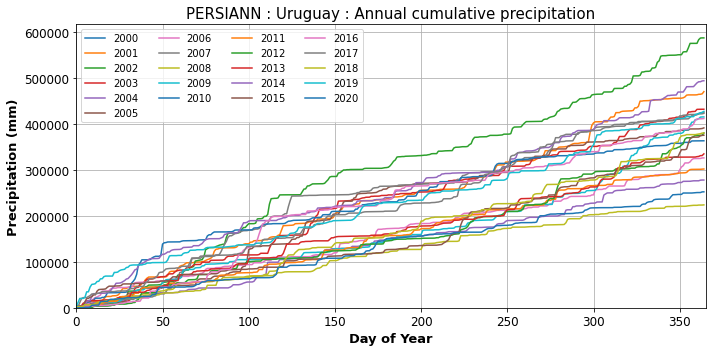

In [ ]:
yearly_analysis(ds_xr, region_polygon, region_title)

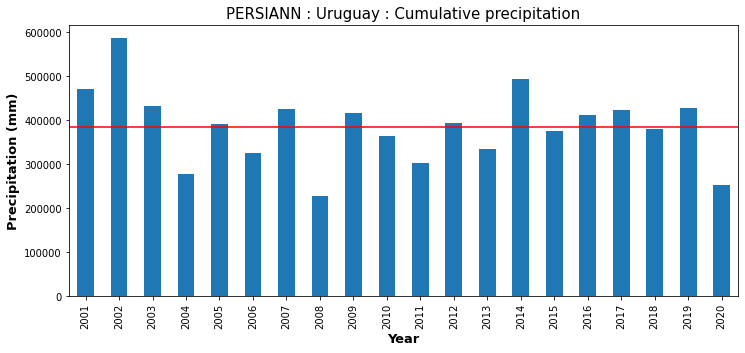

In [ ]:
time_barplot(ds_xr, region_polygon, region_title, period="time.year")

## Season cumulative precipitation 

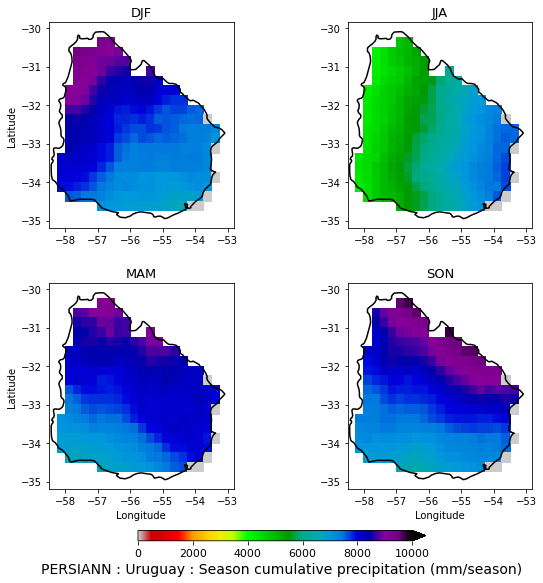

In [ ]:
season_analysis(ds_xr, region_polygon, region_title)

In [ ]:
ds_xr

<xarray.Dataset>
Dimensions:        (time: 7305, lat: 19, lon: 22)
Coordinates:
  * lon            (lon) float32 -58.5 -58.25 -58.0 ... -53.75 -53.5 -53.25
  * lat            (lat) float32 -30.25 -30.5 -30.75 ... -34.25 -34.5 -34.75
  * time           (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2020-12-31
Data variables:
    precipitation  (time, lat, lon) float32 ...
    altitude       (lat, lon) float32 70.5 78.5 65.0 69.0 ... 0.0 0.0 0.0 0.0
Attributes:
    creation_date:       2022-07-27
    author:              Mario Garcia
    email:               mariogarcia.ar@gmail.com
    algorithm:           PERSIANN
    url:                 https://chrsdata.eng.uci.edu/
    type:                satellite-based precipitation products
    spatial resolution:  0.25
    time resolution:     1 day

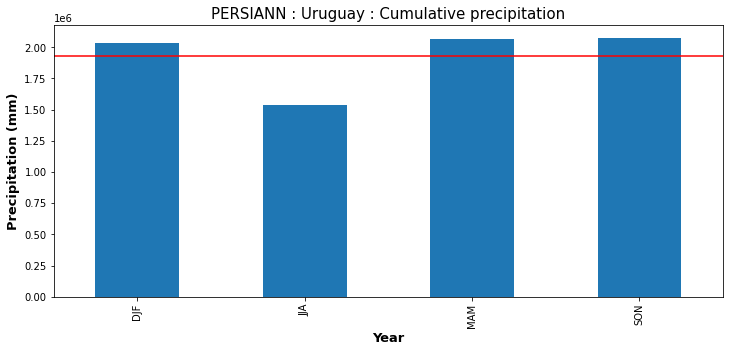

In [ ]:
time_barplot(ds_xr, region_polygon, region_title, period="time.season")

## Monthly cumulative precipitation  

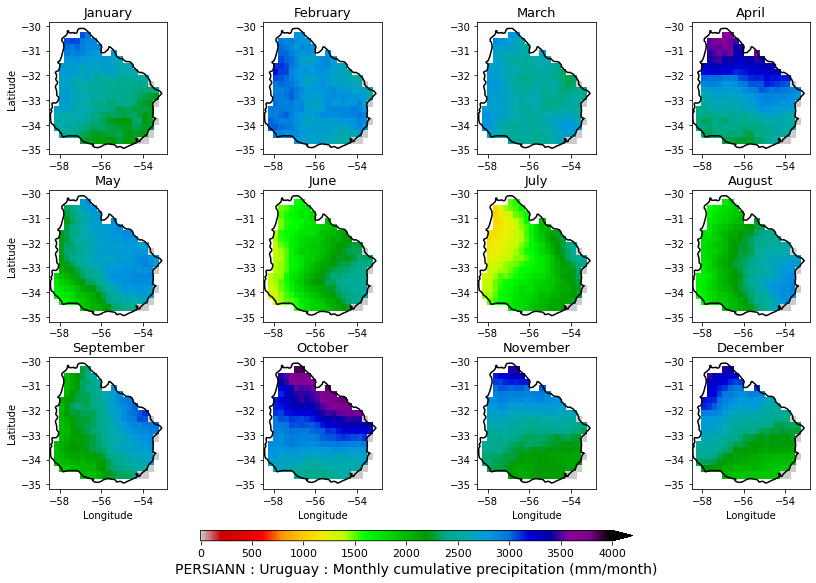

In [ ]:
monthly_analysis(ds_xr, region_polygon, region_title)

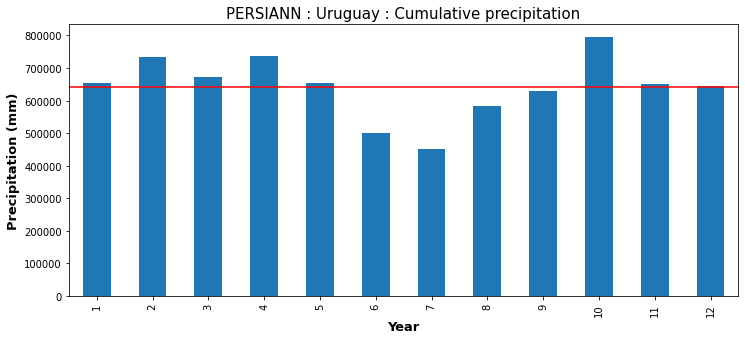

In [ ]:
time_barplot(ds_xr, region_polygon, region_title, period="time.month")


# Departamentos [c004]

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c004Polygon.shp")
region_title = "Departamentos"
region_name = 'nombre'

## Annual cumulative precipitation

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  yearly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.year")  

## Season cumulative precipitation 

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  season_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.season")  

## Monthly cumulative precipitation  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  monthly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombre'])
  time_barplot(ds_xr, region['geometry'], region['nombre'], period="time.month")  

# Cuencas Hidrograficas - Nivel 1 [c097]

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
region_title = "Cuencas"
region_name = 'nombrec1'

## Annual cumulative precipitation

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  yearly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.year")  

## Season cumulative precipitation 

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  season_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.season")  

## Monthly cumulative precipitation  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  monthly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  time_barplot(ds_xr, region['geometry'], region['nombrec1'], period="time.month")  

# checking missing values

In [ ]:
region_polygon = get_geometry_uruguay()
region_masked = get_landmask(ds_xr, region_polygon)
region_masked

In [ ]:
masked_missing = ((ds_xr_raw['precipitation'] < 0) & 
                  (ds_xr_raw['precipitation'] > -999))
ds_xr_missing = ds_xr_raw.where(masked_missing, drop=True)
ds_xr_missing = ds_xr_missing.where(region_masked, drop=True)
ds_xr_missing

In [ ]:
x = ds_xr_missing.to_dataframe()

# x.to_csv('a.csv')
# !head -n 100 a.csv

In [ ]:
xx = x[ x['precipitation'] > -999]
xx

In [ ]:
xxx = xx.reset_index().groupby(['lat','lon']).count()
xxx

In [ ]:
ds_xr_time = ds_xr_time.groupby(period).sum(xr.ALL_DIMS)

In [ ]:
ds_xr

# Las siguientes hay que agruparlas

# Biozonificación integrada de los tetrápodos [c090]

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c090Polygon.shp")
region_title = "Biozonificacion"
region_name = 'subzona'

In [ ]:
region_polygon[ region_polygon['subzona'] == '1A']

## Annual cumulative precipitation

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  yearly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.year")  

## Season cumulative precipitation 

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  season_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.season")  

## Monthly cumulative precipitation  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  monthly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombre'])
  time_barplot(ds_xr, region['geometry'], region['nombre'], period="time.month")  

# Regionales en recursos hídricos [c251]

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c251Polygon.shp")
region_title = "Regional Rec. Hidricos"
region_name = 'sub_cuenca'

## Annual cumulative precipitation

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  yearly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.year")  

## Season cumulative precipitation 

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  season_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  time_barplot(ds_xr, region['geometry'], region[region_name], period="time.season")  

## Monthly cumulative precipitation  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region[region_name])
  monthly_analysis(ds_xr, region['geometry'], region[region_name])  

In [ ]:
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombre'])
  time_barplot(ds_xr, region['geometry'], region['nombre'], period="time.month")  

# vvver


# Cuencas hidrograficas Nivel 1

## Annual cumulative precipitation

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
# region_polygon
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  yearly_analysis(ds_xr, region['geometry'], region['nombrec1'])  

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
# region_polygon
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  time_barplot(ds_xr, region['geometry'], region['nombrec1'], period="time.year")  

## Season cumulative precipitation 

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
# region_polygon
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  season_analysis(ds_xr, region['geometry'], region['nombrec1'])  

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
# region_polygon
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  time_barplot(ds_xr, region['geometry'], region['nombrec1'], period="time.season")  

## Monthly cumulative precipitation  

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
# region_polygon
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  monthly_analysis(ds_xr, region['geometry'], region['nombrec1'])  

In [ ]:
region_polygon = gpd.read_file(dir_data_shapefiles+"/c097Polygon.shp")
# region_polygon
for idx, region in region_polygon.iterrows():
  print("region: ", region['nombrec1'])
  time_barplot(ds_xr, region['geometry'], region['nombrec1'], period="time.month")  


# Cell Analysis

In [ ]:
from shapely import geometry

pointList = pd.DataFrame([
    [-31,-55],
    [-33,-54],
    [-34,-56],
    [-33,-56]],columns=['lat','lon'])
# pointList

poly = geometry.Polygon([[p.lon, p.lat] for index, p in pointList.iterrows()])
poly_serie = gpd.GeoSeries(poly)

# print(poly.wkt)  # prints: 'POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))'

In [ ]:
region_landmask = get_landmask(ds_xr, poly)
# region_landmask

In [ ]:
# coordinate reference system
crs={'init':'epsg:4326'}

geodf_shape = get_geometry_uruguay()

fig, axs = plt.subplots(nrows=1, ncols=1)  

datamap = ds_xr.where(region_landmask)
df_xr_acc = datamap.sum(dim="time")['precipitation']

df_xr_acc.plot(ax=axs, x="lon", y="lat", cmap="Blues", levels=20)
geodf_shape.boundary.plot(ax=axs, color="black")
poly_serie.boundary.plot(ax=axs, color="black")


prec_max = np.round(float(df_xr_acc.max().data), 2)
prec_min = np.round(float(df_xr_acc.min().data), 2)
fig.suptitle(f'Uruguay Region: PERSIANN : Acc Precipitation [{prec_max}, {prec_min}]', fontsize=12)
plt.show()

In [ ]:
!wget http://www.dinama.gub.uy/

In [ ]:
!wget https://data.humdata.org/dataset/d31c3690-b6d9-461c-8ac6-553dd9c69b81/resource/67cfdd31-7a90-49cf-aae2-6bf424a40990/download/ury_admgaz_2020.xlsx

In [ ]:
# https://data.humdata.org/dataset/cod-ab-ury

In [ ]:
!wget https://data.humdata.org/dataset/d31c3690-b6d9-461c-8ac6-553dd9c69b81/resource/67cfdd31-7a90-49cf-aae2-6bf424a40990/download/ury_admgaz_2020.xlsx

In [ ]:
df_uy = pd.read_excel('ury_admgaz_2020.xlsx', sheet_name=1)
df_uy

In [ ]:
!wget https://data.humdata.org/dataset/d31c3690-b6d9-461c-8ac6-553dd9c69b81/resource/75c7c51c-8f05-4b49-8b47-2f94112f986c/download/ury_adm_2020_shp.zip

In [ ]:
!unzip /content/ury_adm_2020_shp.zip

In [ ]:
df_shapes = gpd.read_file("/content/ury_admbnda_adm1_2020.shp")
df_shapes

In [ ]:
artigas = df_shapes.iloc[0]['geometry']
artigas

In [ ]:
for indexs, region in   df_shapes.iterrows():
  # coordinate reference system
  crs={'init':'epsg:4326'}

  region_landmask = get_landmask(ds_xr, region['geometry'])


  geodf_shape = get_geometry_uruguay()

  fig, axs = plt.subplots(nrows=1, ncols=1)  

  datamap = ds_xr.where(region_landmask)
  df_xr_acc = datamap.sum(dim="time")['precipitation']

  df_xr_acc.plot(ax=axs, x="lon", y="lat", cmap="Blues", levels=20)
  geodf_shape.boundary.plot(ax=axs, color="black")
  gpd.GeoSeries(region['geometry']).boundary.plot(ax=axs, color="black")

  region_name = region['ADM1_ES']
  prec_max = np.round(float(df_xr_acc.max().data), 2)
  prec_min = np.round(float(df_xr_acc.min().data), 2)
  fig.suptitle(f'Uruguay Region {region_name} : PERSIANN : Acc Precipitation [{prec_max}, {prec_min}]', fontsize=12)
  plt.show()

In [ ]:
from shapely import geometry
data = np.array([[-31,-55],
    [-33,-54],
    [-34,-56]])
pointList = pd.DataFrame(data,columns=['lat','lon'])
# pointList

poly = geometry.Polygon([[p.lon, p.lat] for index, p in pointList.iterrows()])

print(poly.wkt)  # prints: 'POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))'

# region = regionmask.Regions([outline])


In [ ]:
  # dataplot = ds_xr_month['precipitation'][i-1, :, :].where(landmask)
landmask

In [ ]:
ds_xr_uruguay = ds_xr.where(landmask)
ds_xr_uruguay

In [ ]:
ds_xr_month['altitude'][i-1, :, :].plot()

In [ ]:
geometry_uruguay = get_geometry_uruguay()
geometry_uruguay

In [ ]:
geometry_uruguay = get_geometry_uruguay()
region_landmask = get_landmask(ds_xr, geometry_uruguay)
region_landmask


In [ ]:
data_region = ds_xr.where(region_landmask)

In [ ]:
print(poly)

In [ ]:
region_landmask = get_landmask(ds_xr, poly)
region_landmask

In [ ]:
data_region = ds_xr.where(region_landmask)
data_region['altitude'].plot()

In [ ]:
region_landmask

In [ ]:
data_region = ds_xr.where(region_landmask)
data_region['altitude'].plot()

In [ ]:
landmask

In [ ]:
data_region = ds_xr.where(region_landmask)
data_region['altitude'].plot()
# data_region['altitude'][0, :, :].plot()

In [ ]:
lats = ds_xr['lat'].values
lons = ds_xr['lon'].values

In [ ]:
coords = []
for lat in lats:
  for lon in lons:
    coords.append([lat,lon])
  
df_coords = pd.DataFrame(coords, columns=['lat','lon'])
df_coords['in_uruguay'] = False
df_coords

In [ ]:
point = Point(-55.50,-32.25)
geometry_uruguay.contains(point)

In [ ]:
df_coords['point'] = df_coords.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
df_coords

In [ ]:
df_coords['in_uruguay'] = df_coords.apply(lambda x: geometry_uruguay.contains(x['point']), axis=1)
df_coords

In [ ]:
df_uy_coords = df_coords[df_coords['in_uruguay']==True]
df_uy_coords

In [ ]:
# Plot coords
# df_coords_pivot = df_coords.pivot(index='lat',columns='lon',values='in_uruguay')
# df_coords_pivot.sort_index(ascending=False, inplace=True)
# df_coords_pivot 

In [ ]:
# 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0
# 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
# 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
# 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
# 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
# 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
# 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
# 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
# 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0

In [ ]:
airtemps = xr.tutorial.load_dataset("air_temperature")
airtemps

In [ ]:
mask = regionmask.defined_regions.srex.mask(airtemps)

In [ ]:
# choose a good projection for regional maps
proj = ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

airtemps.isel(time=1).air.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

In [ ]:
x = ds_xr.where(ds_xr['precipitation']>=0).count(dim=['date'])
s = x.to_dataframe()
s['precipitation'].unique()

In [ ]:
2116092 - ( 7671*19*22), ( 7671*19*22)

In [ ]:
# x = ds_xr['precipitation'].isnull().count(dim='date')
# x.to_dataframe()
# x['precipitation'].plot()

# x = ds_xr.where(ds_xr.precipitation == np.nan)
# x.to_dataframe()

x = ds_xr.dropna(dim=["date",'lat','lon'])
x

np.count_nonzero(~np.isnan(data))


# bbb
